# Analysis of Experimental Data of Absorption of CO2 into SIPs containing NOHMs

In this file, we will analyse some of the data sent by Guanhe on the absorption of CO2 at 1 bar into SIPs containing various weight fractions of NOHM-PEI (NPEI).

We have absorption data for 5 different SIPs, containing 9.8wt%, 29.4wt%, 33.3wt%, 49wt% and 58.8wt% NPEI inside Tegorad 2650 PDMS. Each SIP layer was 1mm thick, and gas uptake was measured in a TGA in pure CO2. 

The goal of this document is to analyse the data, in particular to determine the consistency of the *equilibrium* absorption capacities for the different materials, and to explore various approaches to modelling the *kinetics* of the CO2 uptake. The kinetics of the uptake are complicated by the presence of an autocatalytic-type reaction, which causes the system to be strongly *reaction-controlled* at the *start* of the absorption process. However, we expect diffusion-controlled behaviour to be present for at least some of the absorption run. We will consider various approaches to modelling this behaviour. Much of the mathematics is worked out in Chapter 4.7 of the thesis "Solvent Impregnated Polymers for Carbon Capture", and a few relevant equations for the diffusion-limited case are discussed here.

We will begin by calling relevant packages, and we will then make plots of the raw data from Guanhe. We will then refine this data so it only contains the absorption curve we are interested in, and we will make plots of these curves. After this, we will conduct some calculations on the equilibrium capacity and the kinetic uptake of CO2 into the material.

All calculations are conducted in Julia v1.0.2

# 1. Bookeeping 
## 1.1 Call Relevant Packages


In [1]:
using Plots
using Plots.PlotMeasures
using DelimitedFiles
using LaTeXStrings
using Statistics
using LsqFit
using StatsPlots

## 1.2 Load Absorption Data

The absorption data is contained in the CO2_Uptake_Data.txt file, which was previously created from the excel data sent by Guanhe Rim. In this file, the first and second columns are time data and SIP mass data for the 9.8wt% case, the third and fourth colums are time and SIP mass data for the 29.4wt% case, etc.

The units are:
 - Time in Hours
 - Mass in Grams

The file should be stored in the same location as this Jupyter notebook. 

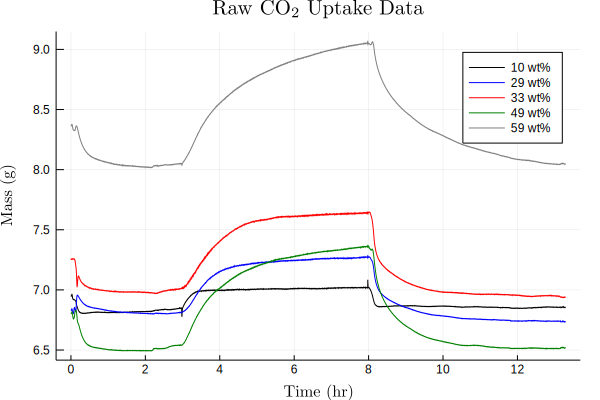

In [2]:
#Read Data
RawUptakeData = readdlm("CO2_Uptake_Data.txt")

#Create Plot of Raw Absorption Data Curves
Plots.scalefontsizes(); Plots.scalefontsizes(1.0)
plot(RawUptakeData[:,1],RawUptakeData[:,2], color="black", linestyle = :solid, xlabel = L"\mathrm{Time\ (hr)}", ylabel = L"\mathrm{Mass\ (g)}", title = L"\mathrm{Raw\ CO_2\ Uptake\ Data}", label = "10 wt%")
plot!(RawUptakeData[:,3],RawUptakeData[:,4], color="blue", linestyle = :solid, label = "29 wt%")
plot!(RawUptakeData[:,5],RawUptakeData[:,6], color="red", linestyle = :solid, label = "33 wt%")
plot!(RawUptakeData[:,7],RawUptakeData[:,8], color="green", linestyle = :solid, label = "49 wt%")
plot!(RawUptakeData[:,9],RawUptakeData[:,10], color="grey", linestyle = :solid, label = "59 wt%")


Create array containing just the absorption isotherms. This array will have the same structure as the RawUptakeData array: the first and second columns will contain time and mass data for the 10wt% curves, the third and fourth columns will contain time and mass data for the 29wt% curve, etc.

In each case, CO2 uptake begins at a time step just before 3 hrs, at which point the temperature, which has been cooling since the 2 hr mark, has just begun to stabilise. The exact step at which CO2 absorption begins is row 3349 in RawUptakeData, and continues for exactly 5 hours to row 8974. All timesteps in RawUptakeData are the same (3.2 seconds, or 1125 samples per hour), and all curves will be shifted to start at t = 0 at the begining of absorption. Likewise, all absorption isotherms will be shifted so that they begin with initial mass of 0.

We will also convert the units to SI:

 - Time in seconds
 - Mass in kilograms.


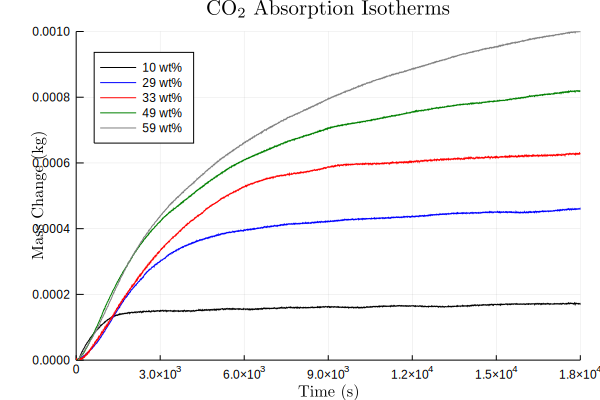

In [3]:
SorptionIsothermData = RawUptakeData[3349:8974,:]
for i in 1:2:9 SorptionIsothermData[:,i] = (SorptionIsothermData[:,i] .- SorptionIsothermData[1,i]) .* 3600 end
for i in 2:2:10 SorptionIsothermData[:,i] = (SorptionIsothermData[:,i] .- SorptionIsothermData[1,i]) ./ 1000  end

#Create Plot of Absorption Isotherms
Plots.scalefontsizes(); Plots.scalefontsizes(1.0)
plot(SorptionIsothermData[:,1],SorptionIsothermData[:,2], color="black", linestyle = :solid, xlabel = L"\mathrm{Time\ (s)}", ylabel = L"\mathrm{Mass\ Change\ (kg)}", title = L"\mathrm{CO_2\ Absorption\ Isotherms}", label = "10 wt%", legend = :topleft, xlims = (0,18000), ylims = (0.0,1.0e-3))
plot!(SorptionIsothermData[:,3],SorptionIsothermData[:,4], color="blue", linestyle = :solid, label = "29 wt%")
plot!(SorptionIsothermData[:,5],SorptionIsothermData[:,6], color="red", linestyle = :solid, label = "33 wt%")
plot!(SorptionIsothermData[:,7],SorptionIsothermData[:,8], color="green", linestyle = :solid, label = "49 wt%")
plot!(SorptionIsothermData[:,9],SorptionIsothermData[:,10], color="grey", linestyle = :solid, label = "59 wt%")



# 2 Analysis of Equilbrium Capacities

We will calculate the amount of CO2 stored in the NPEI phase of each of these materials. The mass of each film is given by the mass measured in the TGA at the very beginning of absorption, after all water has evaporated off; this will be the mass in row 3349 in RawUptakeData. We will define the NPEI mass fractions in MassFractions, and we will define the film masses in kg in SIPMasses. We will then calculate the moles of CO2 absorbed per gram of NPEI from the beginning to the end of the 5 hour absorption run. Visually, it looks like this will be the saturation concentration within the SIP containing 10wt% NPEI, but the other SIPs don't quite looke like they've reached saturation.
 
In order to account for the CO2 solubtility in the PDMS, we will use a solubility for pure CO2 in PDMS at 25C, interpolated from Scholes et al. (2010) from the Journal of Membrane Science, Table 3. This gives S = 5.94e-4 mol/m3.Pa. It could be argued that the solubility of CO2 in the PDMS may be lowered by the presence of residual N2 - but this only affects the calculation by $\pm 10\%$, as the CO2 stored in the PDMS is much less than the CO2 stored in the NOHM. We will assume a density of PDMS of 965 kg/m3.




In [4]:
#We store the NPEI mass fractions in MassFractions
MassFractions = [0.098, 0.294, 0.333, 0.49, 0.588]

#We store the SIP film masses in SIPMasses
SIPMasses = RawUptakeData[3349,2:2:10]*1e-3                 #kg

#Define density and CO2 solubtility within PDMS.
SPDMS = 5.94e-4                                             #mol/m3.Pa
ρPDMS = 965                                                 #kg/m3

#Define CO2 Pressure
PCO2 = 1e5                                                  #Pa

#Calculate moles of CO2 stored in 1kg of NPEI after absorption for each of
#the 5 absorption runs.
MaxMolesCO2PerKgNPEI = [((SorptionIsothermData[end,2*i] - SorptionIsothermData[1,2*i])/0.044 - SIPMasses[i]*(1-MassFractions[i])/ρPDMS*SPDMS*PCO2)/(SIPMasses[i]*MassFractions[i]) for i = 1:5]

5-element Array{Float64,1}:
 5.331265964050388 
 5.086517558313053 
 5.988789005949926 
 5.7513900100120425
 4.764651594744481 

Each of the various absorption isotherms predicts an equilibrium (after 5 hours) CO2 capacity of between ~5-6 mol CO2/kg SIP. The final, 58.8wt% sample gives a slightly lower capacity, however this is unsurprising given that the isotherm looks as though it has not reached complete equilibrium. The same could be said for the 33wt% and 49wt% uptake curves to a lesser extent.

We see the relatively consistent results from the following bar chart.

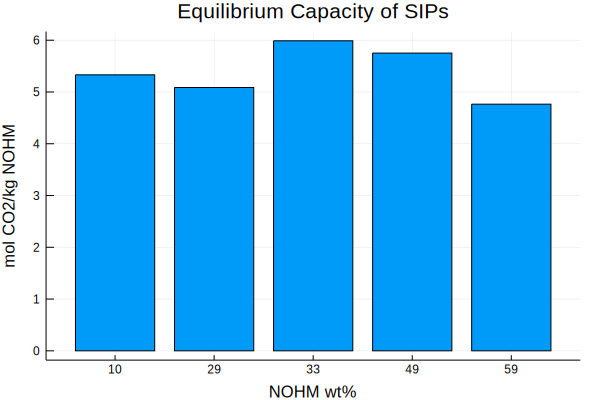

In [5]:
bar(["10","29","33","49","59"],MaxMolesCO2PerKgNPEI,title = "Equilibrium Capacity of SIPs",legend=false, xlabel="NOHM wt%",ylabel="mol CO2/kg NOHM")

Ignoring the 59wt% run, the mean capacity appears to be around 5.5mol/kg.


In [6]:
mean(MaxMolesCO2PerKgNPEI[1:end-1])


5.539490634581353

## 2.1 Summary of Equilibrium Analysis
Overall, the total amount of CO2 absorbed by each sample is consistent and within experimental error. According to the raw data, the NOHM-PEI in each sample is absorbing about 5.5 mol CO2/kg at equilibrium in the presence of 1 atm of CO2. The slightly smaller values for the 10wt% and 29.4wt% cases could be attributed to experimental error, however we note that if a smaller value for the PDMS solubility is used, the discrepancy is substantially reduced. We have used the solubility of pure CO2 in PDMS, but the presence of N2 is known to reduce the CO2 solubility by a factor of 3 or more (see Scholes et al. (2010), J. Mem. Sci). The sample is likely to initially be saturated in N2, which may not have time to diffuse out of the material as the CO2 is aborbed. Using a smaller CO2 solubility (e.g. S = 2e-5 mol/m3.Pa), the 10wt% and 29.4wt% data points become more consistent, and the average capacity of the NOHM-PEI for each run increases to a value closer to 6mol CO2/kg SIP. Similarly, the slightly smaller NOHM-PEI capacities for the 49wt% and 58wt% cases can be attributed to the fact that these absorption runs have not yet reached equilibrium. 

# 3. Analysis of Kinetics

There are two approaches to analysing absorption kinetics for which we already have experimental data: 

1. We can create a model from first principles and compare this to the raw data, or 
2. We can analyse the raw data to look for expected patterns, which we then compare with the predictions of a model.

My preference is always (1), however, for this particular material this option is rather difficult. The main problem is the slow uptake of CO2 at the *start* of absorption, which is likely caused by some form of autocatalytic reaction within the NOHM-PEI. Without more knowledge of the chemistry inside the NOHM, it is difficult to construct a model from first principles which accounts for this behaviour. And even if we assume a reaction mechanism, we would have no independent data on expected reaction rate constants. Of course, we could build a model and *fit* reaction rate constants to the experimental data, but this would be against the spirit of option (1).

Instead, we will go with option (2). At some point in the absorption run, once the autocatalytic reactions have gained steam and a reasonably quantity of CO2 has been absorbed, we expect absorption to be diffusion controlled. This behaviour has been observed in all other SIPs that have been considered to date. In particular, we expect a *saturated-zone* to form near the surface of the SIP, in which all the NOHM-PEI has completely reacted with CO2. Newly-absorbed CO2 must *diffuse* through this saturated zone to reach the unreacted NOHM droplets beneath, and this diffusion is rate-controlling. 

## 3.1 Behaviour of Curve During Diffusion-Controlled Regime

For a linear piece of SIP, it is not difficult to show (see Chapter 4 of the above-mentioned thesis) that, for diffusion-controlled behaviour the moles of of CO2 absorbed, $n$, increases as:

$$
n \propto \sqrt{t}
$$

For systems like this, in which there is initially a small time period of reaction-controlled behaviour, it may take a small amount of time before a significant saturated-zone can form. In such cases, we instead expect:

$$
n \propto \sqrt{t-t_0}
$$

where $t_0$ is a lag-time to account for the slow reaction at the start of the absorption run.

We can go a step further, and calculate the exact, expected constant of proportionality. As shown in the thesis (Eq. 4.33), for a diffusion-controlled system, we expect

$$
\frac{n}{n_{max}} = \sqrt{C_1(t-t_0)}
$$

where $n_{max}$ is the maximum number of moles of CO2 which can be absorbed into the material (at saturation) and $C_1$ is given by:

$$
C_1 = \frac{2p_{CO2}}{N_{SIP}L^2_{SIP}}((1-\varepsilon)P_l + \varepsilon P_s)
$$

where $p_{CO2}$ is the partial pressure of CO2 in the gas, $N_{SIP}$ is the saturated volumetric capacity of the SIP (in mol CO2/m3 SIP), $L_{SIP}$ is the thickness of the SIP (in m), $\varepsilon$ is the volume  fraction of the solid (PDMS) and $P_l$ and $P_s$ are the CO2 permeabilities in the liquid (NOHM) and solid (PDMS) phases, respectively.

If diffusion-limited behaviour occurs, we expect a plot of $n^2\ vs\ t$ to have a linear region given by:

$$
n^2 = [n_{max}^2C_1]t - [n_{max}^2 C_1 t_0]
$$

The presence of such a linear region in this plot would be strong evidence of diffusion-limited behaviour. Furthermore, we can calculate $n_{max}$ from the equilibrium data discussed above, and so the slope and y-intercept of the linear region would allow us to calculate values of $C_1$ and $t_0$. We can then compare the value of $C_1$ calculated from the data with the theoretical value given by the equations above.

## 3.2 Plots of $n^2\ \mathrm{vs}\ t$
### 3.2.1 10wt% NOHM

We begin with the SIP containing 10wt% NPEI. A plot of $n^2$ vs $t$ looks as follows:

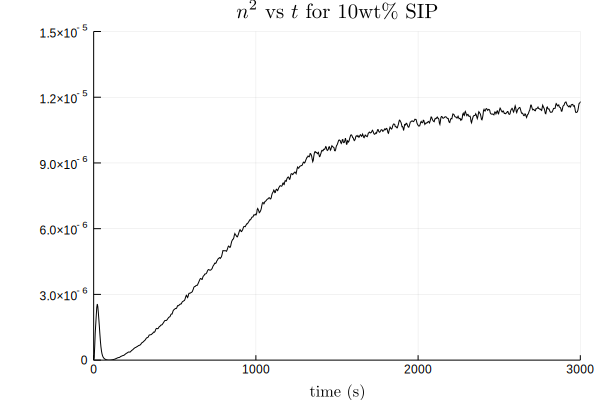

In [7]:
plot(SorptionIsothermData[:,1],(SorptionIsothermData[:,2]/.044).^2, xlabel = L"\mathrm{time\ (s)}", color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 10wt\%\ SIP}", xlims = (0,3000), ylims = (0, 1.5e-5), legend = :topleft,label="")

There is a clear linear region, which persists through most of the absorption regime, approximately from $t = 300\mathrm{s}$ to $t = 1400\mathrm{s}$. The trend only fails to hold at the beginning (when the autocatalytic reactions are slow, and so the reaction is rate-controlling) and at the end (as the material approaches saturation, and once again the reaction become slow enough to be rate controlling.) We now find a line-of-best-fit through this region, of the form:

$$
n^2 = at + b
$$

and plot this on the $n^2$ vs $t$ plot:

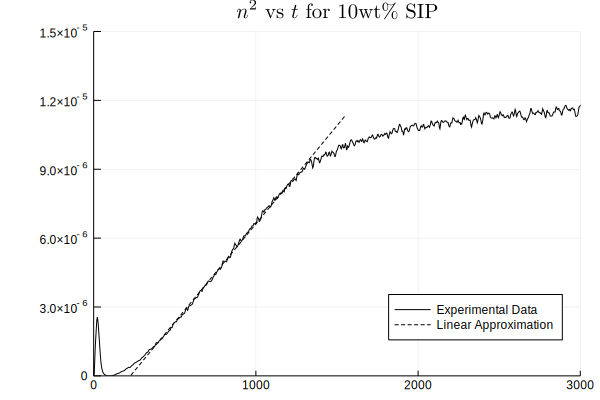

In [8]:
#Define a linear model with two parameters,
@. model(x, p) = p[1]*x + p[2]

#Fit the model to the experimental data by minimising the sum of squares error:
fit = curve_fit(model, SorptionIsothermData[95:407,1],(SorptionIsothermData[95:407,2]./0.044).^2,[1e-7,0.0])
fit_vals_10 = coef(fit)            #Vector of coefficients a and b for linear fit.

#Recreate Plot with fitted values
plot(SorptionIsothermData[:,1],(SorptionIsothermData[:,2]/.044).^2, color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 10wt\%\ SIP}", xlims = (0,3000),ylims=(0,1.5e-5),label = "Experimental Data", legend = :bottomright)
plot!(LinRange(0,1550,100), t -> fit_vals_10[1]*t+fit_vals_10[2],color="black",linestyle = :dash,label="Linear Approximation")


The fit seems quite reasonable. We can now use the fitted values $a$ and $b$ to plot the prediction of the diffusion-limited regime against the original uptake data. Comparing 

$$
n^2 = at + b
$$

with 

$$
n^2 = [n_{max}^2C_1]t - [n_{max}^2 C_1 t_0]
$$

we see that $a = n_{max}^2C_1$ and $b = -n_{max}^2C_1t_0$. In terms of these variables, the diffusion-limited model given above may be expressed as:

$$
n = n_{max}\sqrt{C_1(t-t_0)} = \sqrt{a(t+b/a)}
$$

We now plot this curve against the experimental uptake data. The dotted region shows the times at which the $n^2$ vs $t$ curve was linear (and so we expect diffusion-limited behaviour) while the dotted line is slightly longer, and shows the extrapolation into the reaction-controlled region in which diffusion-limited behaviour is inaccurate.

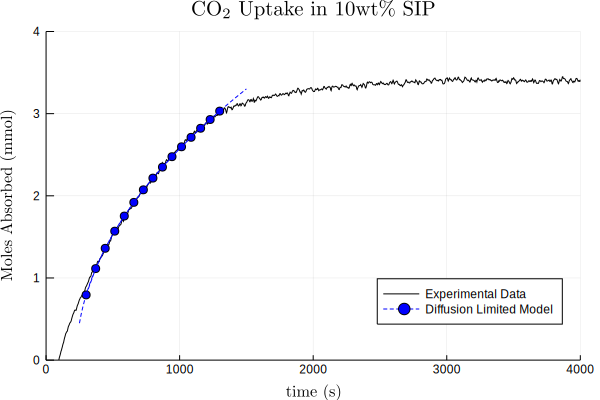

In [9]:
plot(SorptionIsothermData[:,1],1000*SorptionIsothermData[:,2]./0.044,color="black", linestyle = :solid,xlims=(0,4000),ylims=(0,4),legend=:bottomright,label="Experimental Data", title = L"\mathrm{CO_2\ Uptake\ in\ 10wt\%\ SIP}", xlabel = L"\mathrm{time\ (s)}", ylabel = L"\mathrm{Moles\ Absorbed\ (mmol)}")
plot!(LinRange(300,1300,15), t -> 1000*sqrt(fit_vals_10[1]*(t+fit_vals_10[2]/fit_vals_10[1])),marker=:circle,color="blue",linestyle=:dash,label="Diffusion Limited Model")
plot!(LinRange(250,1500,100), t -> 1000*sqrt(fit_vals_10[1]*(t+fit_vals_10[2]/fit_vals_10[1])),color="blue",linestyle=:dash,label="")


The existence of the linear region in the $n^2$ vs $t$ plot is quite strong evidence that we have diffusion-controlled behaviour in this system. The diffusion-controlled behaviour governs most of the absorption regime, from around 20% to 80% saturation. 

However, we still need to determine that the slope of the linear region in the $n^2$ vs $t$ plot is physically reasonable. We can do this by comparing the theoretical value of $C_1$, as calculated via the theory:

$$
C_1 = \frac{2p_{CO2}}{N_{SIP}L^2_{SIP}}((1-\varepsilon)P_l + \varepsilon P_s)
$$

with the value inferred from the slope of the $n^2$ vs $t$ plot. 

Before doing this, however, we will analyse the remaining 4 uptake curves to see if they are also diffusion controlled in some regions.

### 3.2.2 29.4wt% NOHM

We now analyse the SIP containing 29.4wt% NPEI. A plot of $n^2$ vs $t$ looks as follows:

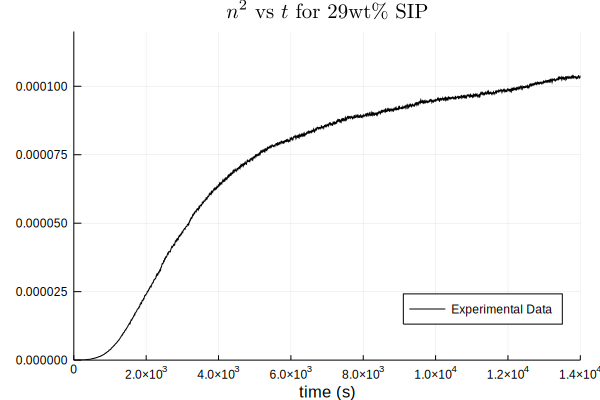

In [10]:
plot(SorptionIsothermData[:,3],(SorptionIsothermData[:,4]/.044).^2, color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 29wt\%\ SIP}", xlims = (0,14000),xlabel = "time (s)", ylim = (0, 0.00012), label = "Experimental Data", legend = :bottomright)

There is a linear region in this plot, though it is less obvious than in the 10wt% case. Graphically, it roughly extends to $t = 1300\mathrm{s}$ to $t = 3500\mathrm{s}$. Following the same procedure as above:

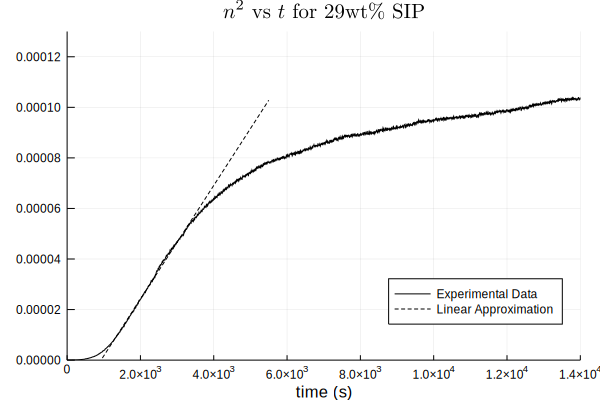

In [11]:
fit = curve_fit(model, SorptionIsothermData[407:1095,3],(SorptionIsothermData[407:1095,4]./0.044).^2,[1e-7,0.0])
fit_vals_29 = coef(fit)

#Recreate Plot with fitted values
plot(SorptionIsothermData[:,3],(SorptionIsothermData[:,4]/.044).^2, xlabel = "time (s)",color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 29wt\%\ SIP}", xlims = (0,14000),ylims=(0,0.00013),label = "Experimental Data", legend = :bottomright)
plot!(LinRange(0,5500,100), t -> fit_vals_29[1]*t+fit_vals_29[2],color="black",linestyle = :dash, label="Linear Approximation")


As above, we now plot the predictions of the diffusion-limited model against the raw uptake data.

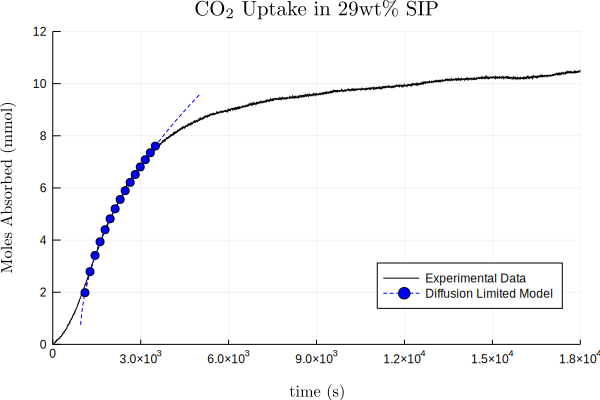

In [12]:
plot(SorptionIsothermData[:,3],1000*SorptionIsothermData[:,4]./0.044,color="black", linestyle = :solid,xlims=(0,18000),ylims=(0,12),legend=:bottomright,label="Experimental Data", title = L"\mathrm{CO_2\ Uptake\ in\ 29wt\%\ SIP}", xlabel = L"\mathrm{time\ (s)}", ylabel = L"\mathrm{Moles\ Absorbed\ (mmol)}",bottom_margin = 5mm)
plot!(LinRange(1100,3500,15), t -> 1000*sqrt(fit_vals_29[1]*(t+fit_vals_29[2]/fit_vals_29[1])),marker=:circle,color="blue",linestyle=:dash,label="Diffusion Limited Model")
plot!(LinRange(950,5000,100), t -> 1000*sqrt(fit_vals_29[1]*(t+fit_vals_29[2]/fit_vals_29[1])),color="blue",linestyle=:dash,label="")


### 3.2.3 33wt% NOHM

We now analyse the SIP containing 33wt% NPEI. A plot of $n^2$ vs $t$ looks as follows:

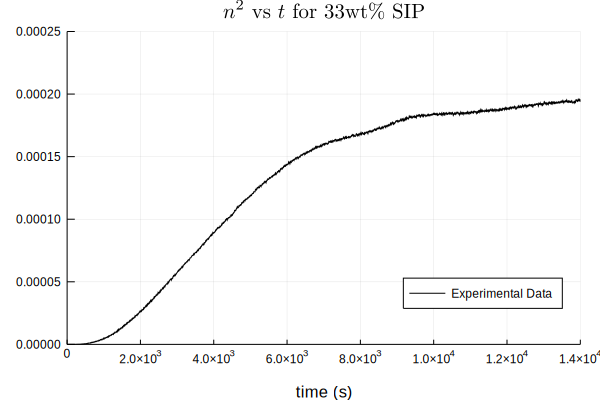

In [13]:
plot(SorptionIsothermData[:,5],(SorptionIsothermData[:,6]/.044).^2, xlabel = "time (s)",color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t \ \mathrm{for\ 33wt\%\ SIP}" ,xlims = (0,14000),ylims=(0,0.00025),label = "Experimental Data", legend = :bottomright,bottom_margin = 5mm)


This has a very nice linear region - substantially clearer than the 29.4wt% case, though I don't know why that would be the case. It extends roughtly from $t = 1500s$ to $t = 5500s$, and we fit the curve over this region:

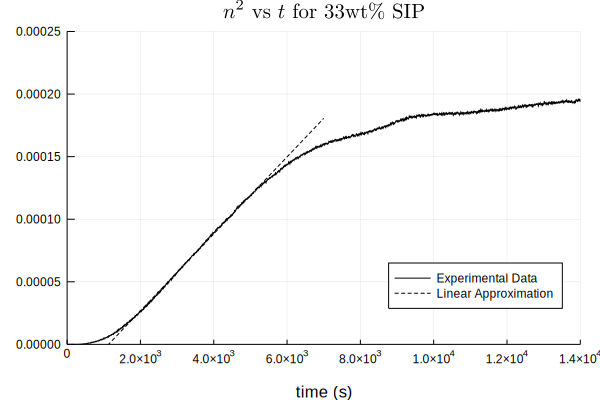

In [14]:
fit = curve_fit(model, SorptionIsothermData[470:1720,5],(SorptionIsothermData[470:1720,6]./0.044).^2,[1e-7,0.0])
fit_vals_33 = coef(fit)

#Recreate Plot with fitted values
plot(SorptionIsothermData[:,5],(SorptionIsothermData[:,6]/.044).^2, color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 33wt\%\ SIP}", xlims = (0,14000),ylims=(0,0.00025),label = "Experimental Data", legend = :bottomright,bottom_margin = 5mm)
plot!(LinRange(0,7000,100), t -> fit_vals_33[1]*t+fit_vals_33[2],xlabel = "time (s)",color="black",linestyle = :dash, label = "Linear Approximation")


Comparing this with the original uptake curve gives:

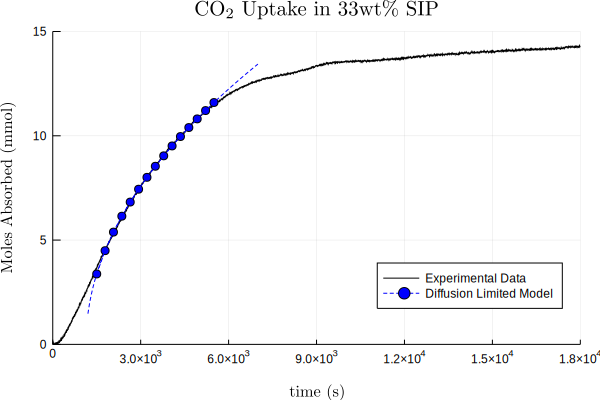

In [15]:
plot(SorptionIsothermData[:,5],1000*SorptionIsothermData[:,6]./0.044,color="black", linestyle = :solid,xlims=(0,18000),ylims=(0,15),legend=:bottomright,label="Experimental Data", title = L"\mathrm{CO_2\ Uptake\ in\ 33wt\%\ SIP}", xlabel = L"\mathrm{time\ (s)}", ylabel = L"\mathrm{Moles\ Absorbed\ (mmol)}",bottom_margin = 5mm)
plot!(LinRange(1500,5500,15), t -> 1000*sqrt(fit_vals_33[1]*(t+fit_vals_33[2]/fit_vals_33[1])),color="blue",marker=:circle,linestyle=:dash,label="Diffusion Limited Model")
plot!(LinRange(1200,7000,100), t -> 1000*sqrt(fit_vals_33[1]*(t+fit_vals_33[2]/fit_vals_33[1])),color="blue",linestyle=:dash,label = "")


### 3.2.4 49wt% NOHM

We now analyse the SIP containing 49wt% NPEI. A plot of $n^2$ vs $t$ looks as follows:

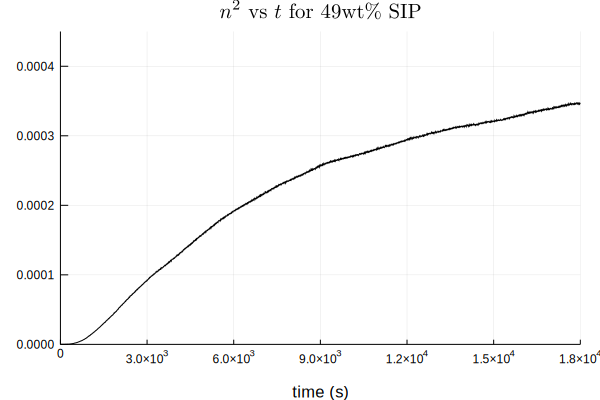

In [16]:
plot(SorptionIsothermData[:,7],(SorptionIsothermData[:,8]/.044).^2, xlabel = "time (s)",color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 49wt\%\ SIP}", xlims = (0,18000),ylims=(0,0.00045),label = "", legend = :topleft,bottom_margin = 5mm)


Unfortunately, it is not so clear that we have a linear region in this uptake curve - there is certainly not a region as clear as there was in the previous 3 SIPs. It's possible that for more concentrated SIPs we don't have simple, diffusion-limited behaviour. We'll continue the analysis above in any case. Fitting a straight line from t = 1500s to t = 5000s gives.



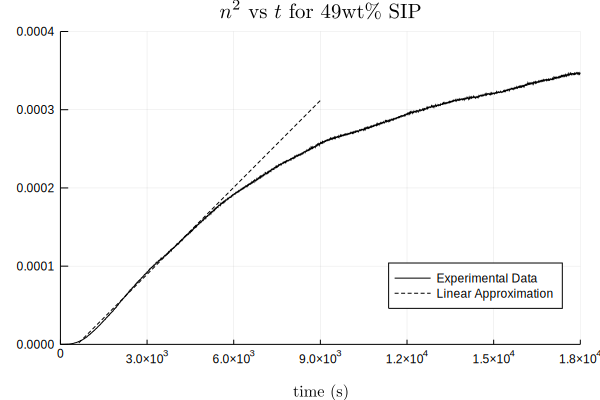

In [17]:
fit = curve_fit(model, SorptionIsothermData[470:1566,7],(SorptionIsothermData[470:1566,8]./0.044).^2,[1e-7,0.0])
fit_vals_49 = coef(fit)

#Recreate Plot with fitted values
plot(SorptionIsothermData[:,7],(SorptionIsothermData[:,8]/.044).^2, color="black", linestyle = :solid, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 49wt\%\ SIP}", xlabel = L"\mathrm{time\ (s)}", xlims = (0,18000),ylims=(0,0.0004),label = "Experimental Data", legend = :bottomright, bottom_margin = 5mm)
plot!(LinRange(0,9000,100), t -> fit_vals_49[1]*t+fit_vals_49[2],color="black",linestyle = :dash,label = "Linear Approximation")


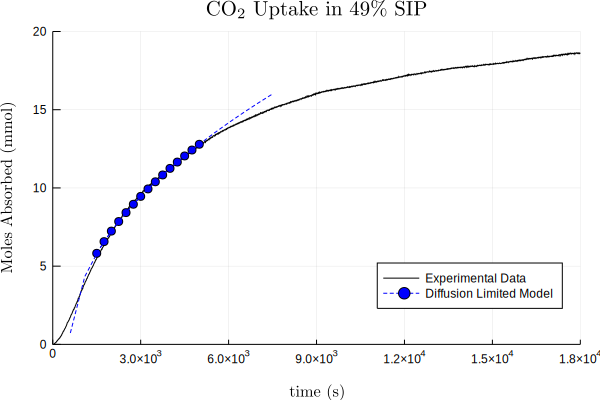

In [18]:
plot(SorptionIsothermData[:,7],1000*SorptionIsothermData[:,8]./0.044,color="black", linestyle = :solid,xlims=(0,18000),ylims=(0,20),legend=:bottomright,label="Experimental Data", title = L"\mathrm{CO_2\ Uptake\ in\ 49\%\ SIP}", xlabel = L"\mathrm{time\ (s)}", ylabel = L"\mathrm{Moles\ Absorbed\ (mmol)}",bottom_margin = 5mm)
plot!(LinRange(1500,5000,15), t -> 1000*sqrt(fit_vals_49[1]*(t+fit_vals_49[2]/fit_vals_49[1])),color="blue",marker=:circle,linestyle=:dash,label = "Diffusion Limited Model")
plot!(LinRange(600,7500,15), t -> 1000*sqrt(fit_vals_49[1]*(t+fit_vals_49[2]/fit_vals_49[1])),color="blue",linestyle=:dash,label = "")


### 3.2.5 58wt% NOHM

We now analyse the SIP containing 58wt% NPEI. A plot of $n^2$ vs $t$ looks as follows:

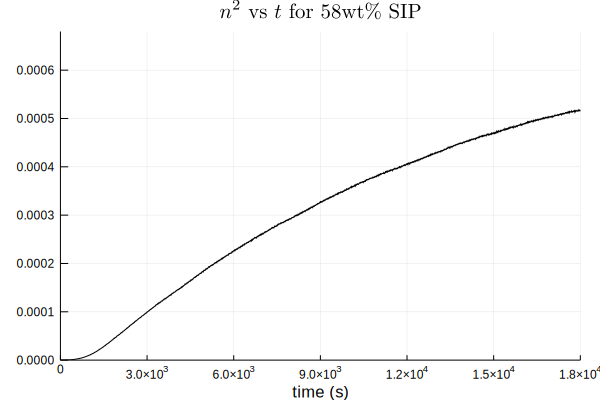

In [19]:
plot(SorptionIsothermData[:,9],(SorptionIsothermData[:,10]/.044).^2, xlabel = "time (s)", color="black", linestyle = :solid,  title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 58wt\%\ SIP}", xlims = (0,18000),ylims=(0,0.00068),label = "", legend = :topleft)


As in the 49wt% case, there is no obvious linear region. Fitting a curve from t = 1500 (when the autocatalytic behaviour seems to have sped up) to t = 5000 gives:

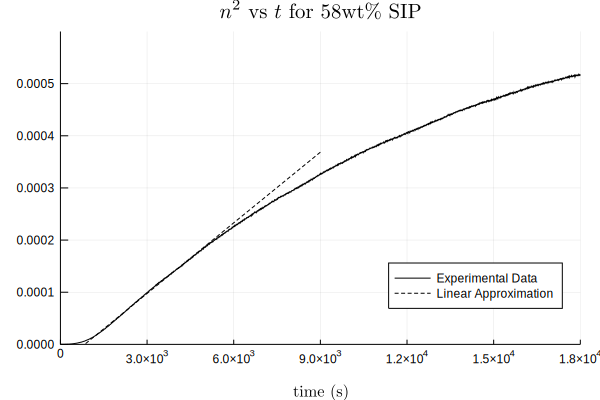

In [20]:
fit = curve_fit(model, SorptionIsothermData[470:1566,9],(SorptionIsothermData[470:1566,10]./0.044).^2,[1e-7,0.0])
fit_vals_58 = coef(fit)

#Recreate Plot with fitted values
plot(SorptionIsothermData[:,9],(SorptionIsothermData[:,10]/.044).^2,  color="black", linestyle = :solid,xlabel=L"\mathrm{time\ (s)}",bottom_margin=5mm, title = L"n^2\ \mathrm{vs}\ t\ \mathrm{for\ 58wt\%\ SIP}", xlims = (0,18000),ylims=(0,0.0006),label = "Experimental Data", legend = :bottomright)
plot!(LinRange(0,9000,100), t -> fit_vals_58[1]*t+fit_vals_58[2],color="black",linestyle = :dash,label="Linear Approximation")


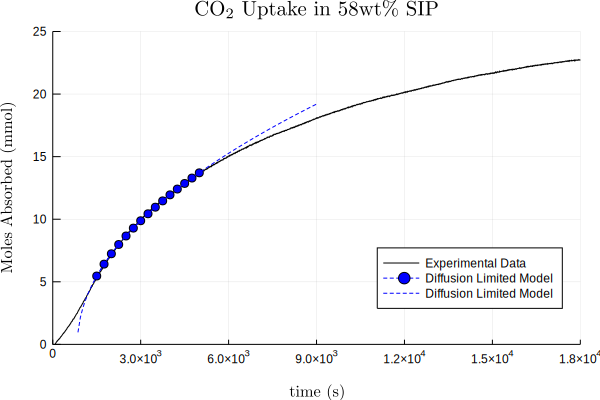

In [21]:
plot(SorptionIsothermData[:,9],1000*SorptionIsothermData[:,10]./0.044,color="black", linestyle = :solid,xlims=(0,18000),ylims=(0,25),legend=:bottomright,label="Experimental Data", title = L"\mathrm{CO_2\ Uptake\ in\ 58wt\%\ SIP}", xlabel = L"\mathrm{time\ (s)}", ylabel = L"\mathrm{Moles\ Absorbed\ (mmol)}",bottom_margin = 5mm)
plot!(LinRange(1500,5000,15), t -> 1000*sqrt(fit_vals_58[1]*(t+fit_vals_58[2]/fit_vals_58[1])),color="blue",marker=:circle,linestyle=:dash,label = "Diffusion Limited Model")
plot!(LinRange(860,9000,100), t -> 1000*sqrt(fit_vals_58[1]*(t+fit_vals_58[2]/fit_vals_58[1])),color="blue",linestyle=:dash, label = "Diffusion Limited Model")

### 3.2.6 Conclusions from $n^2$ vs $t$ Plots

In this section, we have been looking for linear regions in an $n^2$ vs $t$ plot, where $n$ is the moles of CO2 absorbed into the SIP. Such regions would be expected if the absorption is governed by a diffusion-controlled, moving front model. 

We saw very clear evidence of linear regions in both the 10wt% and the 33wt% uptake data. We also saw a reasonably-clear linear region in the 29.4wt% uptake data. 

We did not see quite as clear linear regions in the 49wt% and the 58wt% data, and it's possible that something more complicated may be occuring in these concentrated systems.

While the linear regions are in-themselves quite clear evidence of diffusion controlled behaviour, we can confirm this by analysing the slope of the lines on the $n^2$ vs $t$ plot, from which we can calculate $C_1$, and seeing if this value is consistent with the value which may be calculated from a theoretical moving-front model using known physical parameters. We do this now for each of the 5 materials.

## 4. Comparison with Theory

We will conduct this analysis in two ways:

1. We will compare theoretical and measured values of $C_1$, assuming a SIP thickness of $L = 0.5mm$ (we chose this value because we assume that, in a pure-gas environment, CO2 absorption occurs on both sides of the 1mm piece of SIP, which is equivalent to single-sided absorption into a 0.5mm piece of SIP). 
2. We will use the experimentally measured value of $C_1$ to predict the thickness of the SIPs. We expect this to be close to 0.5mm for double-sided absorption. We do this because it is not entirely clear whether it is more appropriate to model the absorption as single- or double-sided.

## 4.1 Comparison of measured and theoretical $C_1$ values.

From the uptake curves, we have identified regions in which absorption is likely to be diffusion-controlled. From these we may calculate values of $C_1$, which we may compare with the theoretical values. 

From the linear regions of the $n^2$ vs $t$ plots, we have calculated $a$ and $b$ for which:

$$
n^2 = at + b
$$

According to the diffusion-controlled theory, $a = n_{max}^2C_1$ and $b = -n_{max}^2C_1t_0$. Hence, if the theoretical maxumum capacity of each of the SIPs, $n_{max}$, is known, we may estimate a value for $C_1$ via 

$$
C_1 = \frac{a}{n_{max}^2}.
$$ 

We can then compare this with the value predicted by the theory for a diffusion controlled moving front:

$$
C_1 = \frac{2p_{CO2}}{N_{SIP}L^2_{SIP}}((1-\varepsilon)P_l + \varepsilon P_s)
$$

$n_{max}$ may be calculated using the known masses of the SIP pieces, the mass fraction of the SIPs, and the solubility of CO2 inside both the PDMS and the NOHM-PEI. In Section 2, we found that the CO2 capacity of the NOHM-PEI is approximately equal to 5.5 mol CO2/kg NOHM, and we use this value below. We also use the following physical parameters:

 - CO2 Partial Pressure, pCO2 = 1 bar = 100,000 Pa
 - Permeability of CO2 in PDMS saturated with N2 = 1650 barrer = 5.58e-13 mol/m.Pa.s (Scholes et al. J. Mem. Sci. 2010). We weren't sure whether to use the permeability of a pure CO2 stream (~3250 barrer) or the permeability from a CO2/N2 mixture, which is less than this. We decided to use a mixed-gas value, as it's likely that significant quantities of N2 will still be present during the CO2 absorption. 
 - Solubility of CO2 within PDMS = 2e-4 mol/Pa.m3 (See Scholes et a. (2010) - this is also a mixed-gas value - see the previous dot point. The model is insensitive to the exact value of this parameter.)
 - Capacity within NPEI = 5.5 mol/kg
 - We set the density of NPEI at 1250 kg/m3, however this cancels during the calculation, so the exact value is irrelevant.
 - Density of PDMS = 965 kg/m3
 - CO2 Permeability within the NOHM is set to 0, as it is likely to be much less than in the PDMS.
 - $L_{SIP} = 0.5mm$. As noted above, we choose this value because we assume absorption is double-sided. 
 

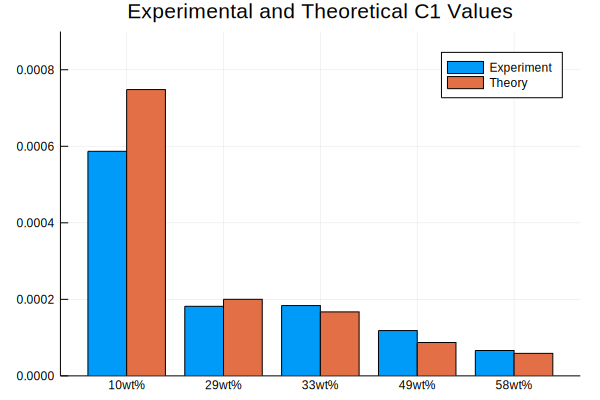

In [22]:
#Define Physical Parameters
SPDMS = 2e-4                                                    #mol/m3.Pa
ρPDMS = 965                                                     #kg/m3
pCO2 = 1e5                                                      #Pressure of CO2 Pa
PPDMS = 5.58e-13                                                #CO2 Permeability of PDMS mol/m.Pa.s
PNPEI = 0                                                       #CO2 Permeability of NPEI mol/m.Pa.s
CapNPEI = 5.5                                                   #CO2 Capacity of NPEI mol/kg
ρNPEI = 1250                                                    #Density of NPEI kg/m3
L_SIP = 0.5e-3                                                  #Thickness of SIP, mm

#Calculate mass and volume fractions for each SIP:
εMass =  [1-MassFractions[i] for i in 1:5]                                     #Mass Fraction of PDMS phase
ε = εMass./ρPDMS ./ (εMass./ρPDMS .+ (1 .-εMass)./ρNPEI)                        #Volume Fraction of PDMS phase

#Calculate values of N_SIP (maximum number of mol CO2/m3 SIP) for each material.
N_SIP = ε.*SPDMS.*pCO2 .+ (1 .-ε).*ρNPEI.*CapNPEI

#Calculate values of n_max (maximum number of mol CO2 inside piece of SIP) for each material.
n_max_SIPs = [SIPMasses[i]*(1-εMass[i])*CapNPEI + SIPMasses[i]*εMass[i]/ρPDMS*SPDMS*pCO2 for i in 1:5]

#Calculate C1 values based on line-of-best-fit in n^2 vs t plots
C1_data = [fit_vals_10[1]/n_max_SIPs[1]^2,fit_vals_29[1]/n_max_SIPs[2]^2,fit_vals_33[1]/n_max_SIPs[3]^2,fit_vals_49[1]/n_max_SIPs[4]^2,fit_vals_58[1]/n_max_SIPs[5]^2]

#Calculate C1 values based on theory
C1_theory = 2 .*pCO2./(N_SIP.*L_SIP^2).*((1 .-ε).*PNPEI .+ ε.*PPDMS);

#Plot these as a bar graph:
groupedbar(["10wt%", "29wt%", "33wt%", "49wt%", "58wt%"], [C1_data C1_theory],title = "Experimental and Theoretical C1 Values",label = ["Experiment","Theory"],ylim=(0,0.0009))

The slopes of the $n^2$ vs $t$ plots are reasonably consistent with the diffusion-controlled theory. The average error is 17%:

In [23]:
mean_error = mean(100*[abs(C1_data[i] - C1_theory[i])/C1_data[i] for i in 1:5])
println("The average error between the theory and the experimentally measured C1 values is ", round(mean_error),"%")

The average error between the theory and the experimentally measured C1 values is 17.0%


Hence, the linear region in the $n^2$ vs $t$ plots has a slope which, within experimental error and uncertainty around the various relevant parameters, is consistent with the basic, diffusion-controlled theory.

## 4.2 Prediction of Thickness of SIPs from Uptake Curve Data

The above analysis can be reworked, so that rather than *assuming* the thickness of the SIP is 0.5mm and calculating theoretical values of $C_1$, we instead use the experimentally measured values of $C_1$ to calculate the SIP thickness that best fits the data. One reason for doing this is that it is not entirely clear whether we should use a thickness of 0.5mm or 1mm for the SIPs, and this is a more objective way of understanding which is more appropriate. 

The average predicted value for the SIP thickness is 0.49mm.


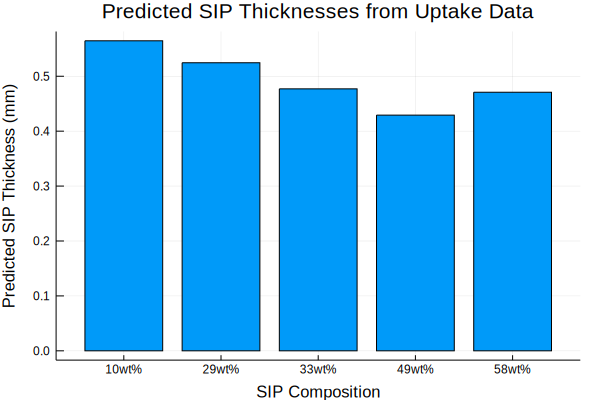

In [24]:
#Calculate C1 values based on line-of-best-fit in n^2 vs t plots
C1_data = [fit_vals_10[1]/n_max_SIPs[1]^2,fit_vals_29[1]/n_max_SIPs[2]^2,fit_vals_33[1]/n_max_SIPs[3]^2,fit_vals_49[1]/n_max_SIPs[4]^2,fit_vals_58[1]/n_max_SIPs[5]^2]

#Calculate predicted L_SIP values based on the uptake curve data
L_SIP_data = sqrt.(2 .*pCO2./(N_SIP.*C1_data).*((1 .-ε).*PNPEI .+ ε.*PPDMS))

#Calculate average value and print.
println("The average predicted value for the SIP thickness is ", round(mean(L_SIP_data*100000))/100, "mm.")

#Plot these as a bar graph:
bar(["10wt%", "29wt%", "33wt%", "49wt%", "58wt%"], L_SIP_data*1e3,ylabel = "Predicted SIP Thickness (mm)", xlabel = "SIP Composition",title = "Predicted SIP Thicknesses from Uptake Data",label = "")

The SIP thicknesses which best fit the uptake data are centered around 0.5mm - indeed the average of these values is 0.49mm. The varaition is reasonable given the various experimental and modelling uncertainties. Hence, the uptake data suggests that the absorption is double-sided. 

# 5. Summary

In this notebook, we have attempted to analyse CO2 uptake data into a complex, multi-phase material, containing a solvent which reacts with CO2 in a complicated and poorly-understood way. However, while the autocatalytic behaviour means it is difficult to model the entirety of the CO2 uptake curve into SIPs containing NOHMs, this doesn't mean we are unable to analyse and understand the data. We have found that the capacity of each of the SIPs is consistent, and we estimate that at saturation the NOHMs within the SIP will contain between 5.5 - 6 mol CO2/kg. By making plots of $n^2$ vs $t$, we have been able to identify several clear linear regions, especially in the 10wt% and 33wt% SIPs, and this is strong evidence of diffusion-limited behaviour. Furthermore, the slopes of these linear regions are consistent with the diffusion-limited theory, and the average error between the theory and the experiment in the calculated parameter, $C_1$, is $\pm 17\%$. If the thickness of the SIP is predicted using the experimental data and the diffusion-limited theory, the various predictions are all close to the true value of 0.5mm. 

Given the complexity of the system, the experimental uncertanities (composition of NOHM and SIP, thickness of SIP, degree of evaporation of water, failure to reach complete saturation etc.) and the modelling uncertainties (rough estimates of NOHM CO2 capacity, rough estimates of CO2 permeability and solubility in PDMS, simplification to diffusion-limited model, etc.) these results seem quite reasonable. We may conclude that it is extremely likely that during most of the absorption run, we have diffusion-controlled, moving-front behaviour inside the SIP.

As a next step, it may be possible to create a more rigorous model which accounts for the autocatalytic reaction. However, such a model will of necessity involve fitting unknown parameters (such as reaction rates) to the experimental data, and I am not convinced of the value of such an approach. 